# Exploratory Data Analysis (EDA) - Sales Dataset

This notebook performs step-by-step EDA and cleaning for `sales_data_sample.csv`.

## 1. Setup and imports
Libraries used: pandas, numpy, matplotlib, seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10,5)

# Adjust this path if your CSV lives elsewhere
DATA_PATH = 'sales_data_sample.csv'

## 2. Load dataset
I used `ISO-8859-1` encoding to handle potential mixed encodings.

In [2]:
df = pd.read_csv(DATA_PATH, encoding='ISO-8859-1')
print('Shape:', df.shape)
df.head()

Shape: (2823, 25)


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,05-07-2003 00:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,07-01-2003 00:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10-10-2003 00:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


## 3. Clean column names
Converting to `lowercase_with_underscores`.

In [3]:
def clean_colname(c):
    c = str(c).strip().lower()
    c = c.replace(' ', '_').replace('-', '_')
    c = ''.join(ch for ch in c if ch.isalnum() or ch=='_')
    c = c.strip('_')
    return c

df = df.rename(columns=lambda x: clean_colname(x))
df.columns

Index(['ordernumber', 'quantityordered', 'priceeach', 'orderlinenumber',
       'sales', 'orderdate', 'status', 'qtr_id', 'month_id', 'year_id',
       'productline', 'msrp', 'productcode', 'customername', 'phone',
       'addressline1', 'addressline2', 'city', 'state', 'postalcode',
       'country', 'territory', 'contactlastname', 'contactfirstname',
       'dealsize'],
      dtype='object')

## 4. Inspect datatypes and missing values
Using `.info()` and `.isnull().sum()`

In [4]:
df.info()

# missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing>0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ordernumber       2823 non-null   int64  
 1   quantityordered   2823 non-null   int64  
 2   priceeach         2823 non-null   float64
 3   orderlinenumber   2823 non-null   int64  
 4   sales             2823 non-null   float64
 5   orderdate         2823 non-null   object 
 6   status            2823 non-null   object 
 7   qtr_id            2823 non-null   int64  
 8   month_id          2823 non-null   int64  
 9   year_id           2823 non-null   int64  
 10  productline       2823 non-null   object 
 11  msrp              2823 non-null   int64  
 12  productcode       2823 non-null   object 
 13  customername      2823 non-null   object 
 14  phone             2823 non-null   object 
 15  addressline1      2823 non-null   object 
 16  addressline2      302 non-null    object 


addressline2    2521
state           1486
territory       1074
postalcode        76
dtype: int64

## 5. Remove duplicates
Use `.drop_duplicates()`

In [5]:
dups_before = df.duplicated().sum()
print('Duplicates before:', dups_before)
df = df.drop_duplicates().reset_index(drop=True)
print('Duplicates after:', df.duplicated().sum())

Duplicates before: 0
Duplicates after: 0


## 6. Standardize text columns
Trim whitespace and normalize country names as example.

In [6]:
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in obj_cols:
    df[c] = df[c].astype(str).str.strip().replace({'nan': pd.NA})

# Example country mapping
country_map = {'usa':'United States','us':'United States','u.s.a.':'United States','france':'France'}
if 'country' in df.columns:
    df['country'] = df['country'].astype(str).str.replace(r'\.+','', regex=True).str.strip()
    df['country'] = df['country'].str.lower().map(country_map).fillna(df['country'])

# show unique countries
if 'country' in df.columns:
    print(df['country'].unique()[:20])

['United States' 'France' 'Norway' 'Australia' 'Finland' 'Austria' 'UK'
 'Spain' 'Sweden' 'Singapore' 'Canada' 'Japan' 'Italy' 'Denmark' 'Belgium'
 'Philippines' 'Germany' 'Switzerland' 'Ireland']


## 7. Parse dates
Convert `orderdate` to `datetime`. Attempt multiple formats.

In [7]:
if 'orderdate' in df.columns:
    df['orderdate'] = pd.to_datetime(df['orderdate'], errors='coerce', dayfirst=False)
    mask = df['orderdate'].isna() & df['orderdate'].notna()
    if mask.any():
        df.loc[mask, 'orderdate'] = pd.to_datetime(df.loc[mask, 'orderdate'], errors='coerce', dayfirst=True)
    print('Unparsed dates:', df['orderdate'].isna().sum())


Unparsed dates: 1305


## 8. Convert numeric columns
Converting price, sales, quantity to numeric types.

In [8]:
num_cols = ['ordernumber','quantityordered','priceeach','sales','qtr_id','month_id','year_id']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(',',''), errors='coerce')

# example: cast ordernumber and quantity to Int64
if 'ordernumber' in df.columns:
    df['ordernumber'] = df['ordernumber'].astype('Int64')
if 'quantityordered' in df.columns:
    df['quantityordered'] = df['quantityordered'].astype('Int64')

df[num_cols].head()

,ordernumber,quantityordered,priceeach,sales,qtr_id,month_id,year_id
0,10107,30,95.70,2871.00,1,2,2003
1,10121,34,81.35,2765.90,2,5,2003
2,10134,41,94.74,3884.34,3,7,2003
3,10145,45,83.26,3746.70,3,8,2003
4,10159,49,100.00,5205.27,4,10,2003


## 9. Handle missing values
Numeric -> mean, Categorical -> mode

In [9]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

for c in num_cols:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].mean())

for c in cat_cols:
    if df[c].isnull().any():
        modes = df[c].mode(dropna=True)
        fill = modes[0] if len(modes)>0 else 'Unknown'
        df[c] = df[c].fillna(fill)

print('Remaining nulls:', df.isnull().sum().sum())

Remaining nulls: 1305


## 10. Visualizations
Top countries by sales, quantity distribution, price boxplot

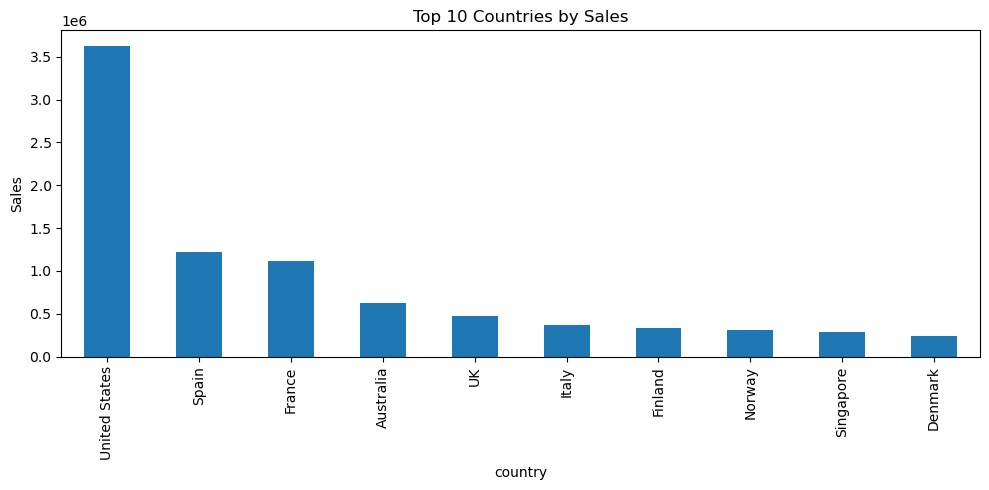

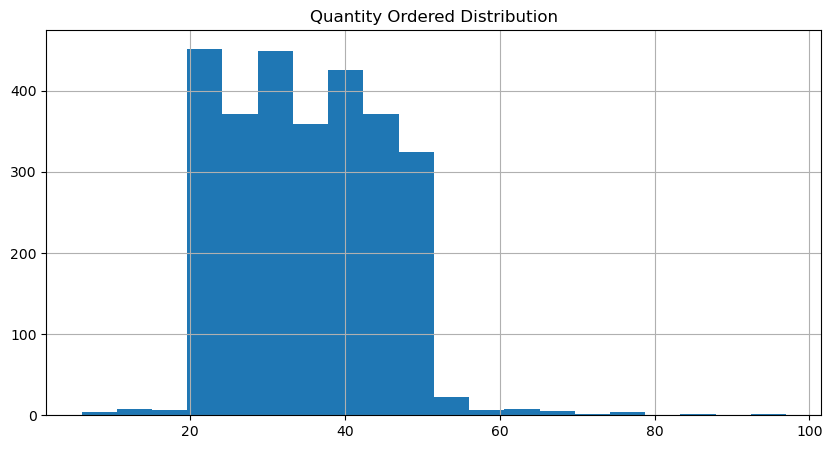

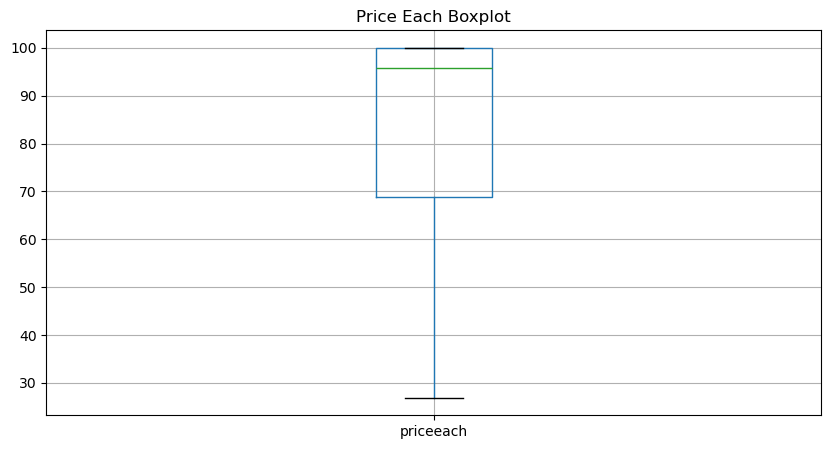

In [10]:
import matplotlib.pyplot as plt
if 'country' in df.columns and 'sales' in df.columns:
    top = df.groupby('country')['sales'].sum().sort_values(ascending=False).head(10)
    top.plot(kind='bar')
    plt.title('Top 10 Countries by Sales')
    plt.ylabel('Sales')
    plt.tight_layout()
    plt.show()

if 'quantityordered' in df.columns:
    df['quantityordered'].hist(bins=20)
    plt.title('Quantity Ordered Distribution')
    plt.show()

if 'priceeach' in df.columns:
    df.boxplot(column='priceeach')
    plt.title('Price Each Boxplot')
    plt.show()

## 11. Save cleaned data
Save cleaned CSV to `sales_data_sample_cleaned.csv`

In [11]:
out_path = 'sales_data_sample_cleaned.csv'
df.to_csv(out_path, index=False)
print('Saved cleaned data to', out_path)

Saved cleaned data to sales_data_sample_cleaned.csv
